# FIT5202 Data processing for Big data

##  Activity: Assignment 2 Part A


##### Student ID: `31265154`
##### Student Name: `Vivekkumar Chaudhari`


### Table of Contents


* [Installing Required Libraries](#install)
* [Data Loading and exploration](#one)
    * [1.1 Data Loading (Task 1 to 4)](#oneone)
    * [1.2 Exploring the data](#onetwo)
        * [1.2.1 Statistics of the data](#onetwoone)
        * [1.2.2 Couting threshold values](#onetwotwo)
        * [1.2.3-a Histogram of Hourly count data](#onetwothreea)
		* [1.2.3-b Trend of Average daily count by month for each year](#onetwothreeb)
		* [1.2.4 Data relationship with label calsses](#onetwofour)
			* [1.2.4.1 Relationship of Sensors to hourly count values ](#onetwofourone)
			* [1.2.4.2 Relationship of Time in a Day to hourly count values](#onetwofourtwo)
* [Feature extraction and ML training](#two)
    * [2.1 Feature selection and preparation of the feature columns](#twoone)
        * [2.1.1 Feature selection](#twooneone)
        * [2.1.2 Creating feature columns](#twoonetwo)
    * [2.2 Preparing Spark ML Transformers/Estimators for features, labels and models](#twotwo)
        * [2.2.1 Transformers, Estimators, and ML Model definations](#twotwoone)
        * [2.2.2 Pipeline definations for use cases](#twotwotwo)
        * [2.2.3 Importance of Hyperparameters](#twotwothree)
	* [2.3 Preparing the training data and testing data](#twothree)
	* [2.4 Training and evaluating models](#twofour)
		* [::: Use case 1: Binary Classification :::](#usecase1)
		* [2.4.1 Training and testing models](#twofourone)
		* [2.4.2 Prediction results](#twofourtwo)
		* [2.4.3 Decision tree feature importance](#twofourthree)
			* [Leaf node splitting criteria](#leafnodesplit)
			* [The top-3 features](#top3features)
		* [2.4.4 Improving prediction for use case 1](#twofourfour)
		* [::: Use case 2: Regression :::](#usecase2)
		* [2.4.5 Training and testing models](#twofourfive)
		* [2.4.6 Computing RMSE and R-squared of models](#twofoursix)
			* [Model Comparision](#modelcomp)
* [Knowledge sharing](#three)
    * [3.1 KMeans clustering model](#threeone)
        * [K-Means Clustering Explanation](#kmeansexplain)
* [Notebook running time ](#runtimeend)

In [1]:
# Import time lib to measure notebook running time
import time
# record start time of notebook
notebook_start_time = time.time()

<a class="anchor" name="install"></a>
# Installing Required Libraries

In [2]:
# Installing all required packages for this assignment
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install datetime
!pip install cycler
!pip install seaborn

<a class="anchor" name="one"></a>
# Data Loading and exploration
<a class="anchor" name="oneone"></a>
## 1.1 Data Loading (Task 1 to 4)

In [3]:
# Importing necessory libraries for this assignment
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import feature as FT
from pyspark.ml import classification as C
from pyspark.ml import regression as R
from pyspark.ml import evaluation as E
from pyspark.ml import Pipeline
from pyspark.ml import clustering as CL
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime as dt
from matplotlib.pyplot import figure
from matplotlib import style
from itertools import chain
from cycler import cycler
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import calendar
import seaborn as sns
%matplotlib inline

## Creating Spark Configuration
# Use all available cores
master = 'local[*]'
# Spark Application name
app_name = 'FIT5202-Assignment-2-A'
# Creating spark session object with default UTC timezone. 
spark = SparkSession.\
    builder.\
    config(conf=SparkConf().\
           setMaster(master).\
           setAppName(app_name).\
           set("spark.sql.session.timeZone", "UTC")).\
    getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# defining the schema of monthly ped. count dataframe
monthly_pad_count_schema = T.StructType([
    T.StructField('ID', T.IntegerType(), True),
    T.StructField('Date_Time', T.TimestampType(), True),
    T.StructField('Year', T.IntegerType(), True),
    T.StructField('Month', T.StringType(), True),
    T.StructField('Mdate', T.IntegerType(), True),
    T.StructField('Day', T.StringType(), True),
    T.StructField('Time', T.IntegerType(), True),
    T.StructField('Sensor_ID', T.IntegerType(), True),
    T.StructField('Sensor_Name', T.StringType(), True),
    T.StructField('Hourly_Counts', T.IntegerType(), True),
])

# defining the schema of sensor location dataframe
sensor_location_schema = T.StructType([
    T.StructField('sensor_id', T.IntegerType(), True),
    T.StructField('sensor_description', T.StringType(), True),
    T.StructField('sensor_name', T.StringType(), True),
    T.StructField('installation_date', T.DateType(), True),
    T.StructField('status', T.StringType(), True),
    T.StructField('note', T.StringType(), True),
    T.StructField('direction_1', T.StringType(), True),
    T.StructField('direction_2', T.StringType(), True),
    T.StructField('latitude', T.FloatType(), True),
    T.StructField('longitude', T.FloatType(), True),
    T.StructField('location', T.StringType(), True),
])

# reading monthly ped. counts csv file to dataframe with header and schema.
df_counts = spark.read.\
            format('csv').\
            option('header', True).\
            option('escape', '"').\
            option('timestampFormat', 'MM/dd/yyyy hh:mm:ss a').\
            schema(monthly_pad_count_schema).\
            load('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')

# reading sensor locations csv file to dataframe with header and schema.
df_sensors = spark.read.\
            format('csv').\
            option('header', 'true').\
            option('escape', '"').\
            option("dateFormat", 'yyyy/MM/dd').\
            schema(sensor_location_schema).\
            load('Pedestrian_Counting_System_-_Sensor_Locations.csv')

# print the schema of monthly ped. count csv dataframe
df_counts.printSchema()
# print the schema of sensor location csv dataframe
df_sensors.printSchema()

# udf function to get label column value as 0 or 1 based on limit 2000 hourly count.
get_threshold = F.udf(lambda cellVal: 1 if cellVal >= 2000 else 0, T.IntegerType())

# Adding new column 'above_threshold' that holds either 0 (< 2000 count) or 1 (>= 2000 count) value. 
df_counts = df_counts.\
    withColumn('above_threshold', get_threshold(df_counts.Hourly_Counts))

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



<a class="anchor" name="onetwo"></a>
## 1.2 Exploring the data
<a class="anchor" name="onetwoone"></a>
### 1.2.1 Statistics of the data

In [4]:
# Get the list of all numerical columns from the monthly count dataframe.
numeric_cols_df_counts = [col for col in df_counts.columns 
                              if (str(df_counts.schema[col].dataType) in ['IntegerType', 'FloatType']) and 
                                  (col not in ['Date_Time', 'above_threshold'])]

# Define operations to perform on numerical columns.
# count: total number of records in the column
# mean: average of all values inside the column
# stddev: standard deviation of all values inside the column
# min: minimum value of all values inside the column
# max: maximum value of all values inside the column
# 25%: 25th percentile of all values inside the column
# 50%: 50th percentile of all values inside the column
# 75%: 75th percentile of all values inside the column
operations = ['count', 'mean', 'stddev', 'min', 'max', '25%', '50%', '75%']

## Method 1: (Total Time: 18.5s)
df_counts.select(numeric_cols_df_counts).summary(operations).show()

## Method 2: (Total Time: 40.1s)
# df_counts.select(numeric_cols_df_counts).toPandas().describe()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|summary|               ID|              Year|             Mdate|              Time|         Sensor_ID|    Hourly_Counts|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          3435106|           3435106|           3435106|           3435106|           3435106|          3435106|
|   mean|        1717553.5|2016.0032330880038|15.751918863639142|11.459955238644746|22.978422791028866|560.7805942524044|
| stddev|991629.8312350252|3.1237869143646275|  8.79918757461428| 6.943473866829414|16.229792156265397|809.9942576353371|
|    min|                1|              2009|                 1|                 0|                 1|                0|
|    max|          3435106|              2020|                31|                23|                71|            15979|
|    25%|           8588

<a class="anchor" name="onetwotwo"></a>
### 1.2.2 Couting threshold values

In [5]:
# Generating total count of above threshold(as 1) value and below threshold(as 0) value.
df_counts.\
    groupBy('above_threshold').\
    agg(F.count('above_threshold').alias('Count')).\
    show()

+---------------+-------+
|above_threshold|  Count|
+---------------+-------+
|              1| 250942|
|              0|3184164|
+---------------+-------+



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
	<div>
	    <strong>Class imbalance problem</strong>
        <p>
            <strong>Observation: </strong><br>
            As you can see in the above count result of <code>above_threshould</code> as <code>1</code> and <code>below_threshould</code> as <code>0</code>, there is clear that 'below_threshould' count has very high compare to 'above_threshould' count.
            <br>
            This result, shows class imbalance between two categories (above_threshould and below_threshould). And data skew is high.
            <br>
            <br>
            <strong>Effect: </strong><br>
            In classification problem, if input (or train) dataset is balanced, then the prediction of a class is more accurate for binary as well as for multiclass classification.
            <br>
            <strong><i>Binary classification:<i/></strong> Here, class <code>0 (below_threshould)</code> has bias result over class <code>1 (below_threshould)</code>. This would cause predicting result more accurate towards one class.
            <br>
        </p>
	</div>
</div>

<a class="anchor" name="onetwothreea"></a>
### 1.2.3-a Histogram of Hourly count data

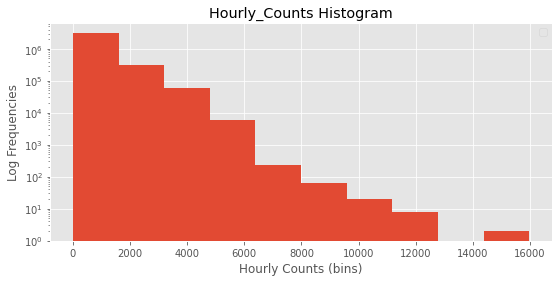

In [6]:
# We are using 'ggplot' style for our drwaing canvas of the graph
style.use('ggplot')
# Seeting graph variables like: Axis label, Title, Legend, Figure size, etc.
plt.figure(figsize=(9, 4))
plt.xlabel("Hourly Counts (bins)")
plt.ylabel("Log Frequencies")
plt.title('Hourly_Counts Histogram')
plt.legend(['Hourly_Counts'])

# Generate the Hourly count data and convert it to panda dataframe and pass this panda dataframe to 
# matplot lib's histogram function with setting our frequancy axis scale to log base 10.
plt.hist(df_counts.select('Hourly_Counts').toPandas()['Hourly_Counts'], log=True)
plt.show()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
	<div>
	    <strong>Hourly_Counts Histogram</strong>
        <p>
            <strong>Observation: </strong><br>
            As you can see in Histogram plot, the bin range between <code>0 to 2000</code> has a maximum amount of frequency than others whereas between <code>13000 to 14000</code> range has <code>zero</code> frequency count.
            <br>
            <br>
            Form the graph, it is clear that, for column <code><i>Hourly_Counts</i></code> the data for different ranges, are not uniformly distributed. And this is a Non-Uniform Histogram for <count>Hourly Count</count> data.
            <br>
            <strong>Effect: </strong><br>
            This will greatly, effect the prediction accuracy of the model in terms of predicting hourly count based on this dataset.
        </p>
	</div>
</div>

<a class="anchor" name="onetwothreeb"></a>
### 1.2.3-b Trend of Average daily count by month for each year

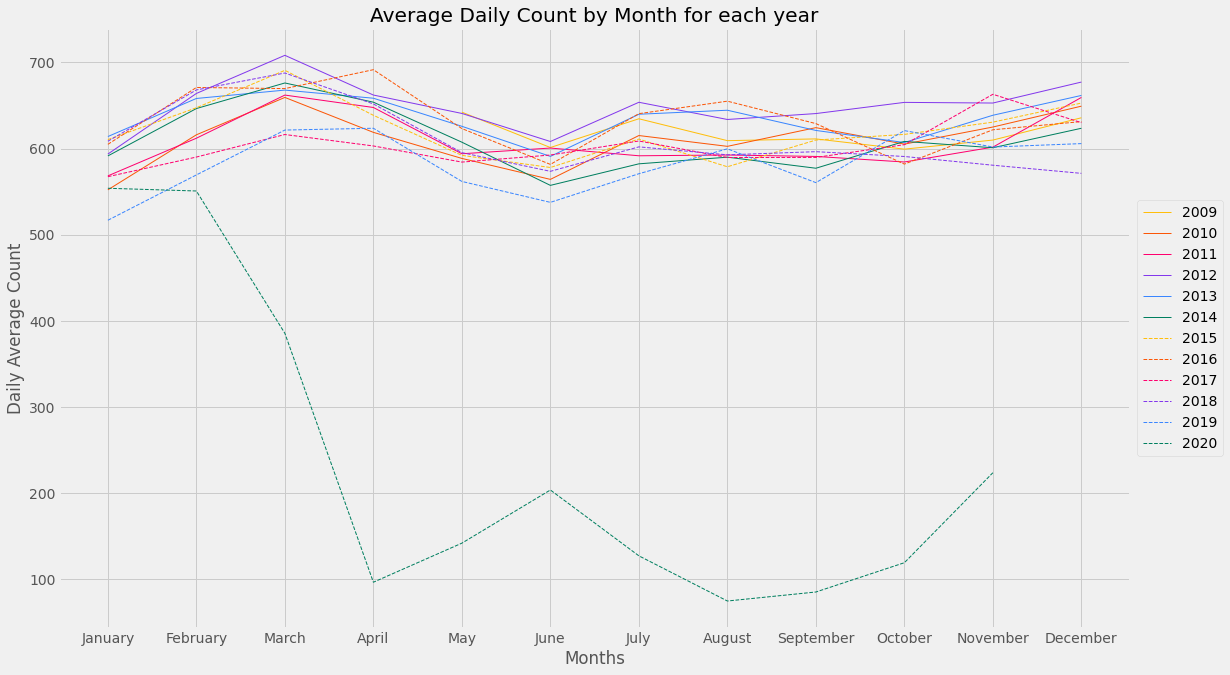

In [7]:
# udf function that return month index from month name as a string.
get_month_index = F.udf(lambda cellVal: { 
    'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr' : 4, 'may' : 5, 'jun' : 6, 
    'jul' : 7, 'aug' : 8, 'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12
    }[cellVal.lower()[:3]], T.IntegerType())

# Finding the average daily count by each month of every year available in the dataset.
pdf_monthly_count = df_counts.\
    groupBy('Year', 'Month').\
    agg(F.avg('Hourly_Counts').alias('Count')).\
    withColumn('Month', get_month_index('Month')).\
    orderBy('Month').\
    select('Year', 'Month', 'Count').\
    toPandas()

## Plot: Average daily count by month for each year from 2009 to 2019. 
# conver dataframe to pivot (grid) Month by Year.
pt = pdf_monthly_count.pivot('Month', 'Year', 'Count')

style.use('fivethirtyeight')
# Apply, different line style after completed line colors for each line in the graph.  
cycler_op2 = cycler('linestyle', ['-', '--', '-', '--', '-']) \
            * cycler('color', ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec', '#3a86ff', '#007f5f'])
plt.rc('axes', prop_cycle=cycler_op2)

ax = plt.figure(figsize=(20, 6)).add_subplot(111)
#add month labels to the x-axis
ticklabels = [dt(1900, item, 1).strftime('%B') for item in pt.index]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels) 

# Seeting graph variables like: Axis label, Title, Legend, Figure size, etc.
ax.plot(pt, linewidth=1)
ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
plt.tight_layout(rect=[0, 0, 0.85, 1.5])
plt.xlabel('Months')
plt.ylabel('Daily Average Count')
plt.title('Average Daily Count by Month for each year')
plt.show()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
	<div>
	    <strong>Monthly Counts Graph</strong>
        <p>
            <strong>Obervation:</strong><br>
            As you can see in the graph, the monthly data flctuation for every year in the dataset is more. However, for the year from 2009 to 2019, the count pattern follows the same behavior.<br>
            <br>
            <code>Starting from Feb to May and Nov and Dec: </code> has higher counts for years from 2009 to 2019.
            <br>
            <code>January and February: </code> has low count across years.
            <br>
            <code>Year 2019: </code> data realtively unmatched (lower counts) compare to other year's patterns.
            <br>
            <code>Year 2012: </code> Higher counts across all years.
            <br>
            <code>Year 2020: </code> A significant decline of counts due to the COVID-19 pandemic.
            <br>
            <strong>Effect: </strong><br>
            From the graph, we can say that for years like 2014, 2015, and 2017 patterns are almost similar. But, for year 2019 and 2012 the <code>Counts</code> lower and higher compare to other years. Also, there is a pattern for some months like Count is higher from month Mid-Feb to Mid-April. So, it is highly likely that a model is very much dependent on the time-series data we have passed as a training dataset. As it follows these patterns behaviors for predicting the classes.
            <br>
        </p>
	</div>
</div>

<a class="anchor" name="onetwofour"></a>
### 1.2.4 Data relationship with label calsses
<a class="anchor" name="onetwofourone"></a>
#### 1.2.4.1 Relationship of Sensors to hourly count values 

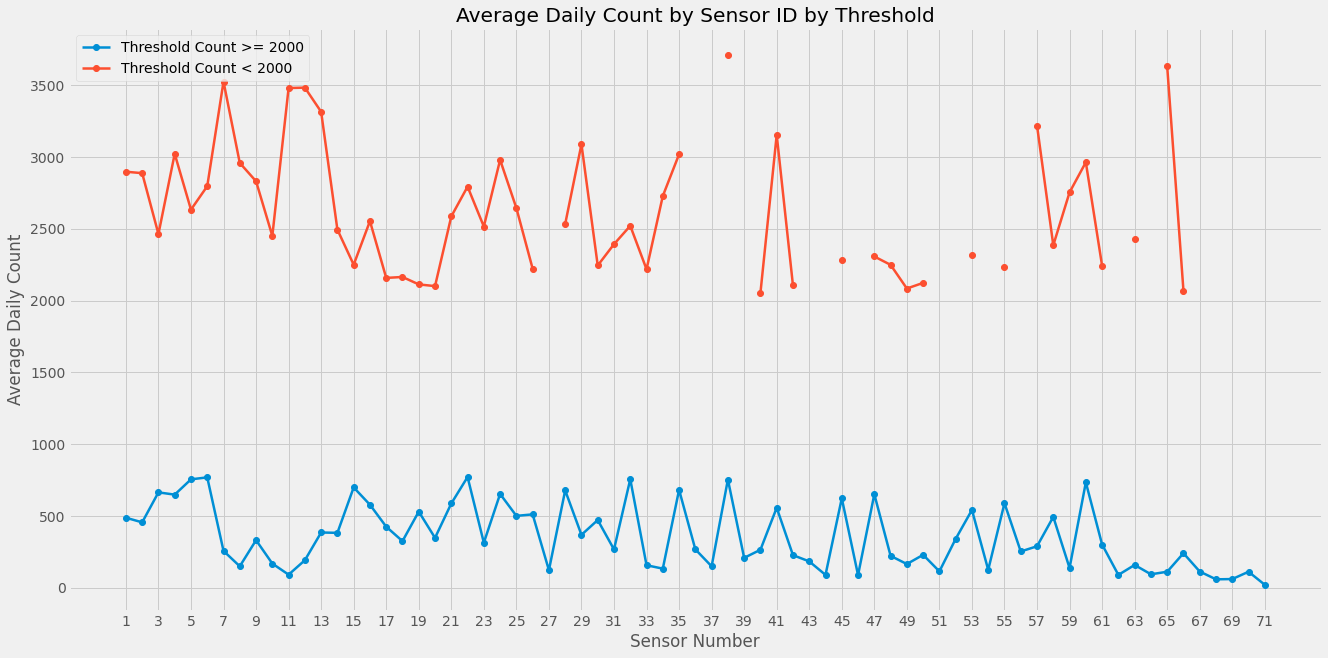

In [8]:
# udf function that return label column text by it's value
change_value = F.udf(lambda cell: '< 2000 Count' if cell == 0 else '>= 2000 Count')

# create panda dataframe of average hourly count by each sensor id from year 2009 to 2020.
pdf_1 = df_counts.\
    groupBy('Sensor_ID', 'above_threshold').\
    agg(F.avg('Hourly_Counts').alias('Count')).\
    withColumn('threshold', change_value('above_threshold')).\
    drop('above_threshold').\
    sort('Sensor_ID').\
    toPandas()

# Using fivethirtyeight style group
style.use('fivethirtyeight')
# Create pivot grid from sensor id, threshold category and average count.
ax = pdf_1.\
    pivot(index='Sensor_ID', columns='threshold', values='Count').\
    plot(figsize=(20,10), linewidth=2.5, kind='line', marker='o', x_compat=True)
sen_list = [num for index, num in enumerate(set(pdf_1['Sensor_ID'].tolist())) if index % 2 == 0]

# setting plotting parameters
plt.xticks(sen_list)
plt.ylabel('Average Daily Count', labelpad=5)
plt.xlabel('Sensor Number')
plt.title(f'Average Daily Count by Sensor ID by Threshold')
plt.legend(['Threshold Count >= 2000', 'Threshold Count < 2000'], loc='upper left')
plt.show()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
	<div>
	    <strong>Average daily count by sensor by threshold</strong>
        <p>
            <strong>About the graph: </strong><br>
            This graph gives insight into average count recorded by each sensor from the year 2009 to 2020 into two different categories: <code>above threshold</code> and <code>below threshold</code>
            <br>
            <code>Sensor 1</code> is installed before <code>sensor 2</code> and so forth.
            <br>
            <br>
            <strong>Observation: </strong><br>
            The graph shows that some sensor <code>27, 36, 37, 39, ...</code> has only recorded count below the threshold value.
            <br>
            <code>Sensor 38: </code> has the highest recorded count even if installed after later the year 2009 because it installed on busy area street.
            <code>Sensor 71: </code> has the lowest recorded count—the newly installed sensor.
            <br>
            <br>
            <strong>Effect: </strong><br>
            In the binary classification model, the prediction is based on the two classes. Here they are above threshold and below threshold. Hence, it is likely the case that, if we test data with a sensor that hasn't recorded above threshold count could get down predicted values.
            <br>
            The other parameter, from the graph, is about the fluctuation of recording count by each sensor has high variance in terms of its location and by its threshold measurement. The threshold measurement gives us insight into data skew of a minimum average count of below threshold values vs. maximum average count of above threshold values.
        </p>
	</div>
</div>

<a class="anchor" name="onetwofourtwo"></a>
#### 1.2.4.2 Relationship of Time in a Day to hourly count values

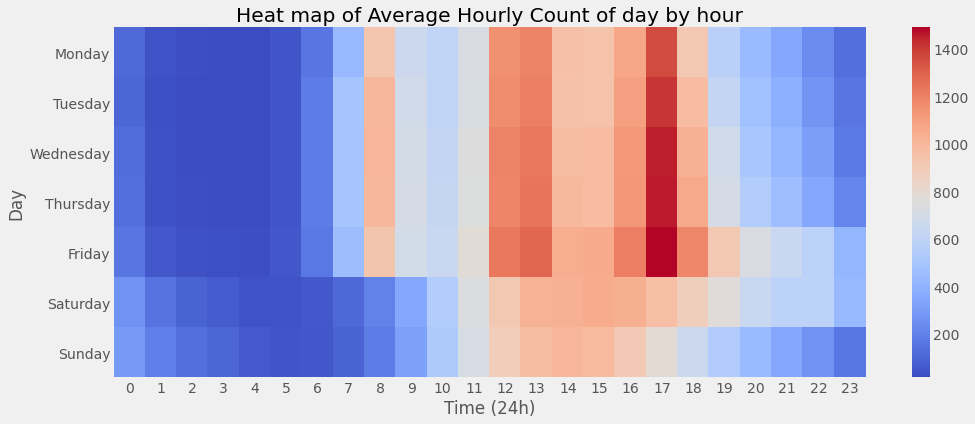

In [9]:
# define category of days for sorting.
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# create panda dataframe for average hourly count for every hour in a day from year 2009 to 2020
pdf_monthly_count = df_counts.\
    groupBy('Day', 'Time').\
    agg(F.avg('Hourly_Counts').alias('Count')).\
    orderBy('Day', 'Time').\
    select('Day', 'Time', 'Count').\
    toPandas()

# Using seaborn-bright style group
style.use('seaborn-bright')
# sort panda column 'Day' as per category 
cat_type = CategoricalDtype(categories=cats, ordered=True)
pdf_monthly_count['Day'] = pdf_monthly_count['Day'].astype(cat_type)

# Create pivot grid from day, time and average count.
pt = pdf_monthly_count.pivot('Day', 'Time', 'Count')
# setting plotting parameters
plt.figure(figsize=(15, 6))
plt.rcParams['figure.facecolor'] = 'white'

# creating heatmap from grid input
sns.heatmap(pt, 
            cmap='coolwarm',
            cbar=True,
           )
plt.title('Heat map of Average Hourly Count of day by hour')
plt.xlabel('Time (24h)')
plt.show()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <div>
        <strong>Heat map for an average hourly count of the day by hour</strong>
        <p>
            <strong>About the graph:</strong> <br>
            This graph shows, average hourly pedestrian count of each day of the week from 2009 to 2020.<br>
            <code>Scale:</code> <br>
            Blue(cold) areas represent meagre count, while red(warm) represents a very high count. <br>
            Average count scale is between 100 to 1500. <br>
            <br> <br>
            <strong>Observation:</strong> <br>
            We can clarify that the peak count is between 8 AM to 7 PM of the day from the map. <br>
            <code>From 12 PM to 1 PM and 4 PM to 7 PM:</code> demand as busy hours of the day. <br>
            <code>Weekends:</code> are quite not busier than the weekdays. <br>
            <code>8 AM - 9 AM:</code> considered as peak hour of the day. <br>
            Overall, we can say weekdays are busier than weekends for the time period between 12 PM and 6 PM.
            <br> <br>
            <strong>Effect:</strong> <br>
            This graph shows the lowest level of fluctuation in time-series data. This is beneficial information we can get to build our time-series prediction model. Obviously, we can find out which time in the day has a peak or the low count. And based on this representation, we can also find out any error or false data present in the dataset or not.
        </p>
    </div>
<div>

In [10]:
# Checking null values in the dataframe
df_counts.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df_counts.columns]).show()

# Result: There are no null values present in any columns. So not required any filtering.

+---+---------+----+-----+-----+---+----+---------+-----------+-------------+---------------+
| ID|Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|Hourly_Counts|above_threshold|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+---------------+
|  0|        0|   0|    0|    0|  0|   0|        0|          0|            0|              0|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+---------------+



<a class="anchor" name="two"></a>
# Feature extraction and ML training
<a class="anchor" name="twoone"></a>
## 2.1 Feature selection and preparation of the feature columns
<a class="anchor" name="twooneone"></a>

<h2>2.1.1 Feature selection</h2><hr><p><strong>Aim:</strong> To use with model building, which includes the <strong><em>Decision Tree model</em></strong>, <strong><em>Gradient Boosted Trees model</em></strong>.</p><p><strong><em>Purpose:</em></strong> To achieve high accuracy, high recall and high F1-score value of the model. And high ROC value indicates the overall confidentiality of a model.</p><hr><p><br></p><table style="width: 100%; margin-right: calc(0%);"><tbody><tr><td colspan="3" style="width: 21.828%; text-align: right;"><strong><span style="font-size: 16px;">Dataset:</span>&nbsp;</strong><br></td><td colspan="4" style="width: 78.1043%; text-align: left;"><strong><span style="font-size: 16px;">Monthly Pedestrian Count</span></strong><br></td></tr><tr><td style="width: 5.6185%; text-align: left;"><strong>Feature Name</strong><br></td><td style="width: 5.0102%; text-align: center;"><strong>Type</strong><br></td><td style="width: 10.6567%; text-align: left;"><strong>About</strong><br></td><td style="width: 16.2627%; text-align: left;"><strong>Relationship with label</strong><br></td><td style="width: 2.8978%; text-align: center;"><strong>Required?</strong><br></td><td style="width: 47.8943%; text-align: left;"><strong>Why?</strong><br></td><td style="width: 10.8464%; text-align: right;"><strong>Categorial Importance to label column</strong></td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">ID<br></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer<br></td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Row identity<br></td><td class="fr-thick" style="width: 16.2627%; text-align: left;">None<br></td><td class="fr-thick" style="width: 2.8978%; text-align: center;">No<br></td><td class="fr-thick" style="width: 47.8943%; text-align: left;">There is no statistical relationship.<br></td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Not Applicable</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Sensor name<br></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">String<br></td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Name of the sensor<br></td><td class="fr-thick" style="width: 16.2627%; text-align: left;">None<br></td><td class="fr-thick" style="width: 2.8978%; text-align: center;">No<br></td><td class="fr-thick" style="width: 47.8943%; text-align: left;">There is no statistical relationship.<br></td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Not Applicable<br></td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Date Time<br></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Date/String<br></td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Datetime when hour count is recorded<br></td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It describes the count of the specific date and hourly time of that day.<br></td><td class="fr-thick" style="width: 2.8978%; text-align: center;">No<br></td><td class="fr-thick" style="width: 47.8943%; text-align: left;">It has statistical data, but those are combined, like data + time for 1-hour count.</td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Not Applicable<br></td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Sensor ID</td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Sensor number that recorded the count</td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It shows which sensor has recorded how much counts.&nbsp;</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">We can use count information by the specific sensor, to derive one sensor relationship among others by its use and location.<br><strong><em><span style="font-size: 12px;">Note: First, tried to break its categorial relationship to the label by OneHotEncoder that creates different 71 features, and, many of them have high importance factors by running Random Forest Classifier. Also, it is biased by training and test data.</span></em></strong></td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Moderate</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Year</td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Year of reading</td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It gives insight information about pedestrian count by the year. Which year has higher or lower the count related to our label&#39;s class categories.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">We use a year-wise category to predict count information for a given year, which includes: frequency of a count by year and by label class (above or below threshold).</td><td class="fr-thick" style="width: 10.8464%; text-align: right;">High</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Month</td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Reading month of a year</td><td class="fr-thick" style="width: 16.2627%; text-align: left;">Same as a year, it gives further detailed information within a specific year.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">It gives monthly fluctuation of the hourly count data in terms of threshold values. Also, describes particular patterns of months every year.</td><td class="fr-thick" style="width: 10.8464%; text-align: right;">High</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">DayofMonth<br><strong><em><span style="font-size: 12px;">(converted)</span></em></strong></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Reading day of a month.<br>This feature converted from <em>&#39;Day&#39;&nbsp;</em>column of the input dataset<br></td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It shows how hourly counts changed day by day for a given month. Which day has above or below threshold counts? That mostly repeated over specific months of the year and so.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">It gives daily fluctuation of the hourly count data in terms of threshold values.<br>Also, as discussed in <strong><em>point 1.2.4.2:</em></strong> describes day patterns of the month, but there are outliers, which does not fit into these patterns like public holidays. But those still repeats for years.&nbsp;</td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Very High</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">Time</td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Reading time of a day</td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It gives the lowest level of detail about count fluctuation by the hour within a day. This is the main parameter and holds closest information regards to our labels.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">The information it holds as discussed in <strong><em>point 1.2.4.2</em></strong>:<br>Busy hours of a day, &nbsp;minimal count of the day, busy time changes related to that day(weekday or weekend). This would also help to filter out data while preparing training and testing datasets as we likely want to achieve active day information or not.<br><span style="font-size: 12px;"><strong><em>Note: It has a very high importance value to the label, finding it by Random Forest Classifier.</em></strong></span></td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Extreme</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">DayofWeek<br><em><strong><span style="font-size: 12px;">(New feature)</span></strong></em></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">Day of a week (1=Mon, 2=Tue, ..., 7=Sun).<br></td><td class="fr-thick" style="width: 16.2627%; text-align: left;">It gives a categorical relationship to label classes.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">Holds information about week-days(Monday to Sunday) patterns. This information is useful for eliminating day-wise count outlier as it represents weekly day-wise counts for each month of every year.</td><td class="fr-thick" style="width: 10.8464%; text-align: right;">High</td></tr><tr><td class="fr-thick" style="width: 5.6185%; text-align: left;">QuarterofYear<br><em><strong><span style="font-size: 12px;">(New feature)</span></strong></em><br></td><td class="fr-thick" style="width: 5.0102%; text-align: center;">Integer</td><td class="fr-thick" style="width: 10.6567%; text-align: left;">A Quarter of a year (1=Jan to Mar, 2=Apr to Jun, 3=Jul to Sep, 4=Oct to Dec)</td><td class="fr-thick" style="width: 16.2627%; text-align: left;">Divide a year into four parts, and shows which quarter has higher or lower count values.</td><td class="fr-thick" style="width: 2.8978%; text-align: center;">Yes</td><td class="fr-thick" style="width: 47.8943%; text-align: left;">Offers a variety of information like the last quarter of every year is busier than any other and some of the quarter has silent data counts.<br><strong><em><span style="font-size: 12px;">Note: It has a high importance value, finding it by Random Forest Classifier.</span></em></strong><span style="font-size: 12px;"><br></span></td><td class="fr-thick" style="width: 10.8464%; text-align: right;">Very High</td></tr></tbody></table><p><br></p><p><strong><em>Note:</em></strong> From the above observation, we are using a total of seven different input features to our models. All of them (except &#39;<em>Sensor ID&#39;)</em> has a categorial relationship with our target class.</p>

<a class="anchor" name="twoonetwo"></a>
### 2.1.2 Creating feature columns

In [11]:
# udf function that return month index from month name as a string.
get_month_index = F.udf(lambda cellVal: { 
    'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr' : 4, 'may' : 5, 'jun' : 6, 
    'jul' : 7, 'aug' : 8, 'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12
    }[cellVal.lower()[:3]], T.IntegerType())

# Creating required and not required column list. 
required_cols = ['Date_Time', 'Year', 'Month', 'Mdate', 'Time', 'Sensor_ID', 'Hourly_Counts', 'above_threshold']
drop_cols = [dc for dc in df_counts.columns if dc not in required_cols]

# udf function to get converted 0AM to 24.
convert_time = F.udf(lambda cellVal: cellVal if cellVal > 0 else 24, T.IntegerType())

# Bulding desire dataframe to create training and testing datasets.
# Only required features for input dataset to model: (Total 7 features selected)
# Sensor_ID: As discussed above, its gives flctuation information by each sensor.
# Year, Month, Date of Month, Time: Basic columns for time-series data model.
# above_threshold: as a label column.
# DayofWeek, QuarterOfYear: New features, to retrive very useful information about the label prediction.
df_final = df_counts.\
    drop(*drop_cols).\
    withColumn('Time', convert_time('Time')).\
    filter(F.col('Time').between(9, 23)).\
    withColumn('Month', get_month_index(F.col('Month'))).\
    withColumnRenamed('Mdate', 'DayofMonth').\
    withColumn('DayofWeek', F.dayofweek(F.col('Date_Time'))).\
    withColumn('QuarterofYear', F.quarter(F.col('Date_Time'))).\
    drop('Date_Time').\
    withColumnRenamed('above_threshold', 'label')

# Showing 10 records of finalised feature-dataframe.
df_final.show(10)

+----+-----+----------+----+---------+-------------+-----+---------+-------------+
|Year|Month|DayofMonth|Time|Sensor_ID|Hourly_Counts|label|DayofWeek|QuarterofYear|
+----+-----+----------+----+---------+-------------+-----+---------+-------------+
|2019|   11|         1|  17|       34|          300|    0|        6|            4|
|2019|   11|         1|  17|       39|          604|    0|        6|            4|
|2019|   11|         1|  17|       37|          216|    0|        6|            4|
|2019|   11|         1|  17|       40|          627|    0|        6|            4|
|2019|   11|         1|  17|       36|          774|    0|        6|            4|
|2019|   11|         1|  17|       29|          644|    0|        6|            4|
|2019|   11|         1|  17|       42|          453|    0|        6|            4|
|2019|   11|         1|  17|       43|          387|    0|        6|            4|
|2019|   11|         1|  17|       44|           27|    0|        6|            4|
|201

<a class="anchor" name="twotwo"></a>
## 2.2 Preparing Spark ML Transformers/Estimators for features, labels and models
<a class="anchor" name="twotwoone"></a>
### 2.2.1 Transformers, Estimators, and ML Model definations

In [12]:
# All input features are has categorial relationship with the label except Sensor ID, 
# and that is required to be present as it is to predict the output class.
# so here, we are only encoding Sensor ID feature.
category_cols = ['Sensor_ID']
input_cols_ohe = category_cols
output_cols_ohe = [f"{c}_ohe" for c in category_cols]

# Encoding sensor ID column through OneHotEncoder
stage_encoder = FT.OneHotEncoder(inputCols=input_cols_ohe, outputCols=output_cols_ohe, handleInvalid='keep')

# Input columns for Vector Assembler
usecase1_input_cols = [c for c in df_final.columns if c not in ['label', 'Hourly_Counts', 'Sensor_ID']] + output_cols_ohe
usecase2_input_cols = [c for c in df_final.columns if c not in ['label', 'Sensor_ID']] + output_cols_ohe

# Passing features directly to vector assembler to create one feature column. 
usecase1_vect_assembler = FT.VectorAssembler(inputCols= usecase1_input_cols, outputCol='features', handleInvalid='error')
usecase2_vect_assembler = FT.VectorAssembler(inputCols= usecase2_input_cols, outputCol='features', handleInvalid='error')

# Creating decision tree classifier model using settings: (after tunning)
# impurity to entropy
# Max Depth to 20
# Max Bin size to 32
usecase1_decision_tree = C.DecisionTreeClassifier(
    featuresCol = 'features', 
    labelCol = 'label', 
    impurity='entropy', 
    maxDepth=20, 
    maxBins=32)

# Creating gradient boosted tree classifier model using settings: (after tunning)
# Max Depth to 10
# Max Bins to default(32)
# Max Iter to default(20)
usecase1_gradient_boosted = C.GBTClassifier(
    featuresCol = 'features', 
    labelCol = 'label',
    maxDepth=10,
    maxBins=32)

# Creating decision tree regressor model using default settings.
# impurity: variance
# Max Depth: 5
# Max Bin size: 32
usecase2_decision_tree = R.DecisionTreeRegressor(
    featuresCol = 'features', 
    labelCol = 'Hourly_Counts',
    maxDepth=5,
    maxBins=32)

# Creating gradient boosted tree regressor model using default settings.
# impurity: variance
# Max Depth: 5
# Max Bin size: 32
# Max Iter to default(20)
usecase2_gradient_boosted = R.GBTRegressor(
    featuresCol = 'features', 
    labelCol = 'Hourly_Counts',
    maxDepth=5,
    maxBins=32)

<a class="anchor" name="twotwotwo"></a>
### 2.2.2 Pipeline definations for use cases

In [13]:
# Creating piplines for decision tree and gradient boosted tree for binary classification: Use case 1
usecase1_dt_pipeline = Pipeline(stages=[stage_encoder, usecase1_vect_assembler, usecase1_decision_tree])
usecase1_gbt_pipeline = Pipeline(stages=[stage_encoder, usecase1_vect_assembler, usecase1_gradient_boosted])

# Creating piplines for decision tree and gradient boosted tree for regression: Use case 2
usecase2_dt_pipeline = Pipeline(stages=[stage_encoder, usecase2_vect_assembler, usecase2_decision_tree])
usecase2_gbt_pipeline = Pipeline(stages=[stage_encoder, usecase2_vect_assembler, usecase2_gradient_boosted])

<a class="anchor" name="twotwothree"></a>
### 2.2.3 Importance of Hyperparameters

<h2>Decision Tree - Tuning Hyperparameters</h2><p>We are using the decision tree model for binary classifier and regression. &nbsp;This model has hyperparameters which affect the overall accuracy of the model.</p><p>Here, we follow below matric parameters to measure binary classification <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">model:</span></p><p><span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;"><strong><em>Accuracy:</em></strong> Overall model prediction over positive and negative classes.</span><br><span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;"><strong><em>Recall</em></strong>: Total correct number of prediction over positive classes.</span><br><span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;"><strong><em>The area under ROC:</em></strong> Capability of a model to separate two classes correctly.</span> &nbsp;</p><h3>MaxDepth</h3><p>It refers to different sizes of decision trees. It means how much deep a tree could be. The number of depth in the tree is equal to a number of levels from a tree&#39;s root node.<br><strong><em>Purpose:</em></strong> Creates the longest possible path equals to maxDepth from root node to leaf node.<br><strong><em>Impact:</em></strong> We can say that MaxDepth is inversely proportioning to the training error of the model. It means that higher the depth lower the training error. But this is not always the case if you increase maxDepth too high, the model would become overfit to training data and does not derive important patterns from it. And by setting too low value, it also not good in terms of not setting all patterns. There should be an optimal value for MaxDepth, and we can find it using a random search or using CrossValidator. In our case, time-series data has lots of patterns variable to different features. So it is likely the case that, our model could overfit our train dataset. But tuning with <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">CrossValidator and feature selection get us, perfect binary classification model.</span><br><br></p><h3>MaxBins</h3><p>It represents the number of buns for discretizing continuous features. If we have a categorical feature with 10 unique categories, then we would have to set bin size &gt;=10.<br><strong><em>Purpose:</em></strong> Allow the model to consider more splitting candidate features to make precise grade split decisions.<br><strong><em>Impact:</em></strong> If it is lower then 2 or the maximum number of categories, it degrades the splitting. If too much higher, then cause unnecessary overhead to computation. In our dataset, the highest number of categories for features column is a Sensor ID. So, in our training dataset, it includes a maximum of 60 different categories, so the bin&#39;s optimal size would be 60 or more.&nbsp;</p>
<br>

<a class="anchor" name="twothree"></a>
## 2.3 Preparing the training data and testing data

In [14]:
# Creating test and train dataset to train the model and predict the results using test dataset.
# Condition: train data between year 2014 to 2018 and test data of year 2019

## For Use case 1:
usecase1_train = df_final.drop('Hourly_Counts').filter(df_final.Year.between(2014, 2018))
usecase1_test = df_final.drop('Hourly_Counts').filter(df_final.Year == 2019)

## For Use case 2:
usecase2_train = df_final.drop('label').filter(df_final.Year.between(2014, 2018))
usecase2_test = df_final.drop('label').filter(df_final.Year == 2019)

# Catch the train and test dataset into memory. 
# This would be helpful to make model building and testing faster.
# Also helpful, while using cross validator to tune model's hyper parameters.
usecase1_train.cache()
usecase1_test.cache()

usecase2_train.cache()
usecase2_test.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, Time: int, Sensor_ID: int, Hourly_Counts: int, DayofWeek: int, QuarterofYear: int]

<a class="anchor" name="twofour"></a>
## 2.4 Training and evaluating models
<a class="anchor" name="usecase1"></a>
### ::: Use case 1: Binary Classification :::
<a class="anchor" name="twofourone"></a>
### 2.4.1 Training and testing models

<h3>Running Environment:&nbsp;</h3><p><strong><em>All results of building model and time have taken is in effect to below conditions:</em></strong></p><p><strong><em>Base machine CPU:&nbsp;</em></strong><em>intel CORE i7 9th Gen</em><br><em><strong>Base machine cores:&nbsp;</strong>6 cores</em><br><em><strong>Base machine main memory</strong>: 16 GB</em></p><p><em><strong>Running on battery or plugged-in:&nbsp;</strong>always plugged-in</em></p><p><strong><em>Guest machine core:&nbsp;</em></strong><em>2 cores</em><br><em><strong>Guest machine memory</strong>: 4 GB</em><br><em><strong>Guest machine Acceleration:</strong> VT-x/AMD-v, Nested Paging, KVM Paravirtualization</em></p><p><em><strong>Note:</strong> All assignment tasks run on the Guest machine.</em><br><br></p>

In [15]:
# Fitting train dataset to decision tree model. and getting predictions from test dataset.
usecase1_dt_model = usecase1_dt_pipeline.fit(usecase1_train)
usecase1_dt_prediction_ds = usecase1_dt_model.transform(usecase1_test)

# Fitting train dataset to gradient boosted tree model. and getting predictions from test dataset.
usecase1_gbt_model = usecase1_gbt_pipeline.fit(usecase1_train)
usecase1_gbt_prediction_ds = usecase1_gbt_model.transform(usecase1_test)

<a class="anchor" name="twofourtwo"></a>
### 2.4.2 Prediction results

In [16]:
# Printing confusion matric for both models.
print('Decision tree model prediction result:')
usecase1_dt_prediction_ds.\
    groupBy('prediction', 'label').\
    agg(F.count('*').alias('Count')).\
    withColumnRenamed('label', 'above_threshold').\
    select('above_threshold', 'prediction', 'Count').\
    sort('above_threshold', 'prediction').\
    show()

print('Gradient Boosted tree model prediction result:')
usecase1_gbt_prediction_ds.\
    groupBy('prediction', 'label').\
    agg(F.count('*').alias('Count')).\
    withColumnRenamed('label', 'above_threshold').\
    select('above_threshold', 'prediction', 'Count').\
    sort('above_threshold', 'prediction').\
    show()

Decision tree model prediction result:
+---------------+----------+------+
|above_threshold|prediction| Count|
+---------------+----------+------+
|              0|       0.0|248445|
|              0|       1.0|  6046|
|              1|       0.0|  8366|
|              1|       1.0| 22675|
+---------------+----------+------+

Gradient Boosted tree model prediction result:
+---------------+----------+------+
|above_threshold|prediction| Count|
+---------------+----------+------+
|              0|       0.0|249645|
|              0|       1.0|  4846|
|              1|       0.0|  9882|
|              1|       1.0| 21159|
+---------------+----------+------+



<h3>Result Matric:&nbsp;</h3><p><strong><em>DTC:</em></strong> Decision Tree Classifier<br><strong><em>GBTC:</em></strong> Gradient Boosted Tree Classifier</p><table style="width: 61%; margin-right: calc(39%);"><tbody><tr><td style="width: 27.4384%;"><strong>Above_threshold</strong></td><td style="width: 19.3596%;"><strong>Prediction</strong></td><td style="width: 21.2027%;"><strong>DTC Count</strong></td><td style="width: 32.3448%;"><strong>GBTC Count</strong></td></tr><tr><td style="width: 27.4384%; text-align: center;">0</td><td style="width: 19.3596%; text-align: center;">0</td><td style="width: 21.2027%; text-align: right;">248445<br></td><td style="width: 32.3448%; text-align: right;">249645<br></td></tr><tr><td style="width: 27.4384%; text-align: center;">0</td><td style="width: 19.3596%; text-align: center;">1</td><td style="width: 21.2027%; text-align: right;">6046<br></td><td style="width: 32.3448%; text-align: right;">4846<br></td></tr><tr><td style="width: 27.4384%; text-align: center;">1</td><td style="width: 19.3596%; text-align: center;">0</td><td style="width: 21.2027%; text-align: right;">8366<br></td><td style="width: 32.3448%; text-align: right;">9882<br></td></tr><tr><td style="width: 27.4384%; text-align: center;">1</td><td style="width: 19.3596%; text-align: center;">1</td><td style="width: 21.2027%; text-align: right;">22675<br></td><td style="width: 32.3448%; text-align: right;">21159<br></td></tr></tbody></table><p><br>From the above confusion matric, DTC has a higher amount of correct &#39;above_threshould&#39; (as 1 to 1) prediction than GBTC. In contrast, GBTC has higher prediction with &#39;below_thresold&#39; <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">(as 0 to 0)</span> values. But both models suffer from falsy prediction values (as 0 to 1 OR 1 to 0).<br>Here, the DTC model outperformed the GBTC model in terms of building time, suggesting correct <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">above_threshould value with given train and test dataset.</span><br>As per the discussion on <strong><em>point 2.4.4</em></strong>: If we look at Recall value of both the models GBTC has high recall value then DTC; GBTC has very high Area under the curve (AUC)-Receiver Operating Characteristics (ROC) value. This indicates model effectiveness to distinguish between target classes in binary classification. In addition to that, if we change our test and/or train the dataset and derive the matric, then it might be different. That difference is more for DTC but very minor for GBTC as GBTC model ensembles multiple DT and filters out most effective. The current test dataset DTC is a good choice, but not the best because it may suffer from overfitting (has high variance) while predicting with different input datasets.</p><p><strong><em>Model Persistency</em></strong>:</p><p>After observing all the parameters, if we have to select between current two models with its given settings, then GBTC is a better choice for future prediction data with its high ROC, accuracy and recall values against DTC.</p>

<a class="anchor" name="twofourthree"></a>
### 2.4.3 Decision tree feature importance

<a class="anchor" name="leafnodesplit"></a>
#### Leaf node splitting criteria

In [27]:
# Mapping feature's indexes to column names
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*usecase1_dt_prediction_ds
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

# creating dataframes from:
# mapping feature index, name and its importance value.
df_features = spark.createDataFrame(
    [(idx, name, float(usecase1_dt_model.stages[-1].featureImportances[idx]))
     for idx, name in attrs
     if usecase1_dt_model.stages[-1].featureImportances[idx]],
    ['feature_index', 'feature_name', 'importance'])

tree_str = usecase1_dt_model.stages[-1].toDebugString
tree_str = tree_str[tree_str.index('If'):]

# replacing indexed feature's names to input data columns. 
for attribute in attrs:
    replace_txt = f'feature {attribute[0]} '
    tree_str = tree_str.replace(replace_txt, f' {attribute[1]} ')

# printing the tree that show splitting criteria for leaf nodes where model predict 0 or 1.
print(tree_str)

If ( Time <= 19.5)
   If ( Time <= 11.5)
    If ( Sensor_ID_ohe_38 in {1.0})
     If ( Time <= 9.5)
      If ( DayofWeek <= 1.5)
       If ( DayofMonth <= 15.5)
        Predict: 0.0
       Else ( DayofMonth > 15.5)
        If ( DayofMonth <= 26.5)
         If ( Month <= 2.5)
          Predict: 0.0
         Else ( Month > 2.5)
          If ( Month <= 3.5)
           Predict: 1.0
          Else ( Month > 3.5)
           If ( Month <= 6.5)
            Predict: 0.0
           Else ( Month > 6.5)
            If ( DayofMonth <= 25.5)
             If ( Month <= 10.5)
              If ( Month <= 9.5)
               If ( DayofMonth <= 23.5)
                Predict: 0.0
               Else ( DayofMonth > 23.5)
                If ( Month <= 7.5)
                 Predict: 1.0
                Else ( Month > 7.5)
                 Predict: 0.0
              Else ( Month > 9.5)
               If ( DayofMonth <= 18.5)
                Predict: 1.0
               Else ( DayofMonth > 18.5)
               

<a class="anchor" name="top3features"></a>
#### The top-3 features

In [18]:
# Printing top 3 features for decision tree classifier.
print(f'Top 3 features: ')
df_features.sort(F.col('importance').desc()).limit(3).show(truncate = False)

Top 3 features: 
+-------------+----------------+-------------------+
|feature_index|feature_name    |importance         |
+-------------+----------------+-------------------+
|3            |Time            |0.2158613206707744 |
|44           |Sensor_ID_ohe_38|0.06813968008845213|
|10           |Sensor_ID_ohe_4 |0.05925696496371292|
+-------------+----------------+-------------------+



<a class="anchor" name="twofourfour"></a>
### 2.4.4 Improving prediction for use case 1

<h3>Suggestion 1: Tunning</h3><p><strong><em>With Features:</em></strong></p><p>Feature selection is the early stage process in model building and has high importance as selecting a model with perfect parameters. In our case, we have built up models for Binary classification which can predict two-class results. Furthermore, we used the Decision tree, as well as Gradient, boosted tree (GBT) classifiers to compare prediction results. GBT is a wrapper model around the base model (Decision tree), as it combines many decision trees and produces more powerful ensemble model.<br>One important thing with time-series data prediction is that, to check a categorical relationship with input features by visualizing patterns with our target classes. Sometimes, it happens that training dataset does not include all the possible patterns to accurately build tree models. Like in our case, train data does not include all sensor ids then in test data set or in future input test data. This would lead to the false prediction of target classes. To eliminate it we should filter out our train data such that it holds almost every possible combination of a feature to label relation.<br>There is always a case that, input data is not enough for time-series predictions, so there is always an option to add new feature filtered from existing data or created from it. This would boost the pattern matching more accurate as you are providing a different time range of data to the model. Like in our case we have converted Month of <em>Day</em> string to a number and added two new feature called <em>DayOfWeek&nbsp;</em>and <em>QuarterofYear.&nbsp;</em>But, still, we have many options to includes like <em>WeekOfYear, WeekOfMonth, MonthQuarter, PublicDayOfYear (specific to region), etc.&nbsp;</em>this would defiantly help to create a robust and more accurate model for our use case.<br>Another, thing we can try, is to use a classification model like Random Forest classifier to find out which features are importance by-passing all features to it. <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">But with existing machine limitation and the time limit of the assignment, we can not undergo to test all and find import features and build a perfect model.</span>&nbsp;</p><p><strong><em>With Hyperparameter:</em></strong></p><p>Tuning Hyperparameters with full potential. It means using what maximum optimal number for hyperparameters is. This would require inter-connected high-end machines with more CPUs and main memory.<br>Like in our case, we cannot go more than 64 bin size as it limits with a 64-bit machine. Also, due to hardware limitation, we cannot undergo tunning with gradient boosted trees (&gt;10 maxDepth) as it uses lots of main memory (heap sizes) causes OutOfMemory exception. In those cases, high-performance and more capable machines are required to tune our model with automated tunning algorithms like CrossValidator or TrainValidationSplit.<br>In our case, We could possibly test our Decision Tree model with some lower range values of hyperparameters.</p><h3>Suggestion 2: Using Different Model and Model Optimisation&nbsp;</h3><p><strong><em>Random Forest Classifier for Binary Classification:</em></strong></p><p>According to (Bradley, 2020) Random Forest (RF) outperformed Gradient Boosted Tree (GBT) in terms of Scalability and Performance. GBT trains the trees in asynchronous format, It means if there is any error happen in the previous trained-tree can be eliminated in the next iteration of the tree. While RF trains each tree independently allowing a more robust model and less chance to overfit with train dataset. So with RF, <span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">synchronous</span> tree training can be achieved and result in better performance. So these factors show that we can use RF against GBT and DT to achieve more accurate binary predictions.<br>As per (<span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">Bradley, 2020) Overall training time for RF would be less than GBT when increasing data size but, at the same time, RF&#39;s Mean Squared Error (MSE) goes high compare to GBT.</span></p><p>As Random Forest work parallelly in testing trees, we can speed up the model building process but it may cause, more errors than GBT. So we can optimise our model with selecting features from RF and using the final model as GBT.<br>Model optimisation can also be achieved while using remote clusters machines, where you have true parallelism over your task because every tune parameters are divide across different machine set and run independently result is faster processing and tunning with the combination of hyperparameters, training dataset, testing dataset and models.</p><hr><p><strong><em>Implementation:</em></strong></p><p>Below is the code, I used to auto-tune hyperparameters of the decision tree model to find the best values for binary classification using CrossValidator:</p>
<br>
<strong>Decision Tree Tunning:</strong>
<code>
dtparamGrid = (ParamGridBuilder()
             .addGrid(usecase1_dt_prediction_ds.maxDepth, [5, 10, 16, 20]) # OR usecase1_gbt_prediction_ds.maxDepth
             .addGrid(usecase1_dt_prediction_ds.maxBins, [10, 20, 32]) # OR usecase1_gbt_prediction_ds.maxBins
             .build())
dtevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
dtcv = CrossValidator(estimator = usecase1_dt_pipeline, # OR usecase1_gbt_pipeline
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 3)
dtcvModel = dtcv.fit(usecase1_train)
predictions = dtcvModel.transform(usecase1_test)
print(f"ROC: {E.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction").evaluate(usecase1_dt_prediction_ds)}")
</code>
<br>
<h3>Tunning Results:&nbsp;</h3><p>&nbsp;</p><p>&nbsp;</p><table border="0" cellpadding="0" cellspacing="0" style="border-collapse: collapse;width:583pt;" width="775"><tbody><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;width:103pt;" width="17.677419354838708%"><br></td><td class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-left:none;width:80pt;" width="13.67741935483871%">DCT</td><td class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-left:none;width:80pt;" width="13.67741935483871%">DCT</td><td class="xl66" style="color:black;font-size:15px;font-weight:700;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-left:none;width:80pt;" width="13.67741935483871%">DCT {Selected}</td><td class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-left:none;width:81pt;" width="13.935483870967742%">GBT</td><td class="xl66" style="color:black;font-size:15px;font-weight:700;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-left:none;width:80pt;" width="13.67741935483871%">GBT {Selected}</td><td class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-left:none;width:79pt;" width="13.67741935483871%">GBT</td></tr><tr><td class="xl68" height="38" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:28.2pt;border-top:none;width:103pt;" width="17.677419354838708%">Time Taken</td><td class="xl68" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;width:80pt;" width="13.67741935483871%">00 Minutes: 42.87 Seconds</td><td class="xl68" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;width:80pt;" width="13.67741935483871%">00 Minutes: 44.83 Seconds</td><td class="xl69" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;width:80pt;" width="13.67741935483871%">00 Minutes: 53.58 Seconds</td><td class="xl68" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;width:81pt;" width="13.935483870967742%">03 Minutes: 28.25 Seconds</td><td class="xl69" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;width:80pt;" width="13.67741935483871%">03 Minutes: 25.35 Seconds</td><td class="xl68" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;width:79pt;" width="13.67741935483871%">02 Minutes: 11.93 Seconds</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">MaxDepth (default: 5)</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">10</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">10</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">20</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">10</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">10</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">5</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">MaxBins (deafult: 32)</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">32</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">16</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">32</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">16</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">32</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">32</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">ROC</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.527657108</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.534899671</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.432634224</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.948097152</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.949218031</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.913417593</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">Accuracy</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.93327543</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.933240407</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.949525797</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.948993458</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.948419091</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.938098007</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">Precision</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.792229318</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.791049128</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.789492009</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.813692267</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.813651221</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.832487562</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">Recall</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.523533391</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.524435424</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.730485487</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.688444316</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.681646854</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.539061242</td></tr><tr><td class="xl65" height="19" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;height:14.4pt;border-top:none;">F1-Score</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.630445746</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.630724525</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.758843412</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.745846712</td><td align="right" class="xl67" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;background:#E2EFDA;border-top:none;border-left:none;">0.741822389</td><td align="right" class="xl65" style="color:black;font-size:15px;font-weight:400;font-style:normal;text-decoration:none;font-family:Calibri, sans-serif;text-align:general;vertical-align:bottom;border:.5pt solid windowtext;border-top:none;border-left:none;">0.654386891</td></tr></tbody></table><p><br></p>
<br>
<strong>Finding Accuracy, Recall, Precision, and F1-Score:</strong>
<code>
def compute_metrics(prediction_dataset):    
    TN = prediction_dataset.filter('prediction = 0 AND label = 0').count()
    TP = prediction_dataset.filter('prediction = 1 AND label = 1').count()
    FN = prediction_dataset.filter('prediction = 0 AND label = 1').count()
    FP = prediction_dataset.filter('prediction = 1 AND label = 0').count()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision =  (TP) / (TP + FP)
    recall = (TP) / (TP + FN)
    f1 = 2 / ((1/recall)+(1/precision))
    return accuracy,precision,recall,f1 
</code>
<br>
<strong>Note: </strong>Kernel restarted every time when building a model with different values of tunned hyperparameters for measuring time.
</p><hr><p><br></p><p>References:</p><p>Bradley, J. (2020, August 18). Random Forests and Boosting in MLlib. Databricks. <a href="https://databricks.com/blog/2015/01/21/random-forests-and-boosting-in-mllib.html">https://databricks.com/blog/2015/01/21/random-forests-and-boosting-in-mllib.html</a></p><p><br></p><p><br></p>

<a class="anchor" name="usecase2"></a>
### ::: Use case 2: Regression :::
<a class="anchor" name="twofourfive"></a>
### 2.4.5 Training and testing models

In [19]:
# Fitting train dataset to decision tree regression model. and getting predictions from test dataset.
usecase2_dt_model = usecase2_dt_pipeline.fit(usecase2_train)
usecase2_dt_prediction_ds = usecase2_dt_model.transform(usecase2_test)

# Fitting train dataset to gradient boosted tree regression model. and getting predictions from test dataset.
usecase2_gbt_model = usecase2_gbt_pipeline.fit(usecase2_train)
usecase2_gbt_prediction_ds = usecase2_gbt_model.transform(usecase2_test)

<a class="anchor" name="twofoursix"></a>
### 2.4.6 Computing RMSE and R-squared of models

In [20]:
# intialize RMSE matric evaluator for regression model.
rmse_evaluator = E.RegressionEvaluator(
    metricName="rmse", 
    labelCol="Hourly_Counts",
    predictionCol="prediction")

# intialize R2 matric evaluator for regression model.
r2_evaluator = E.RegressionEvaluator(
    metricName="r2", 
    labelCol="Hourly_Counts",
    predictionCol="prediction")

# evaluate the matrics for RMSE
dt_rmse = rmse_evaluator.evaluate(usecase2_dt_prediction_ds)
gbt_rmse = rmse_evaluator.evaluate(usecase2_gbt_prediction_ds)

# evaluate the matrics for R2
dt_r2 = r2_evaluator.evaluate(usecase2_dt_prediction_ds)
gbt_r2 = r2_evaluator.evaluate(usecase2_gbt_prediction_ds)

# print the results
print(f'Dcision Tree Regression Model: Root-mean-square error: {dt_rmse}')
print(f'Dcision Tree Regression Model: R-squared: {dt_r2}')
print()
print(f'Gradient Boosted Tree Regression Model: Root-mean-square error: {gbt_rmse}')
print(f'Gradient Boosted Tree Regression Model: R-squared: {gbt_r2}')

Dcision Tree Regression Model: Root-mean-square error: 95.03710923393342
Dcision Tree Regression Model: R-squared: 0.9881647524586066

Gradient Boosted Tree Regression Model: Root-mean-square error: 84.40124838997163
Gradient Boosted Tree Regression Model: R-squared: 0.9906655517774078


<p><a class="anchor" name="modelcomp"></a></p>
<h3>Model Comparision</h3><p><strong><em>Results:</em></strong></p><table style="width: 100%;"><tbody><tr><td style="width: 33.3108%;"><strong>Model</strong></td><td style="width: 33.3333%;"><strong>RMSE</strong> (<strong><span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">Root-mean-square error) (lower is better)</span></strong></td><td style="width: 33.3108%;"><strong>R2&nbsp;</strong>(<span style="color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; background-color: rgb(255, 255, 255); text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">R-squared) (higher is better)</span></td></tr><tr><td style="width: 33.3108%;">Decision Tree Regression <strong style="box-sizing: border-box; font-weight: 700; color: rgb(65, 65, 65); font-family: sans-serif; font-size: 14px; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; text-decoration-thickness: initial; text-decoration-style: initial; text-decoration-color: initial;"><em style="box-sizing: border-box;">(DTR)</em></strong><br></td><td style="width: 33.3333%;">95.03710923393342<br></td><td style="width: 33.3108%;">0.9881647524586066<br></td></tr><tr><td style="width: 33.3108%;"><em>Gradient Boosted Tree Regression&nbsp;</em><strong><em>(GBTR)</em></strong><br></td><td style="width: 33.3333%;">84.40124838997163<br></td><td style="width: 33.3108%;">0.9906655517774078<br></td></tr></tbody></table><p><br><strong><em>Observation:</em></strong></p><p>From the results, we can say that DTR has higher RMSE than GBTR. But we cannot rely only on RMSE value, as it does not give enough information about positive class value errors. We also have to compare prediction results with test dataset summary as below:</p><table style="width: 51%; margin-right: calc(49%);"><tbody><tr><td style="width: 14.6082%;"><strong>Summary</strong></td><td style="width: 19.7876%;"><strong>Test dataset</strong></td><td style="width: 26.2948%;"><strong>DTR prediction dataset</strong></td><td style="width: 39.0438%;"><strong>GBTR prediction dataset</strong></td></tr><tr><td style="width: 14.6082%;"><br></td><td style="width: 19.7876%; text-align: right;"><em>Hourly_Counts</em><br></td><td style="width: 26.2948%; text-align: right;"><em>Hourly_Counts</em><br></td><td style="width: 39.0438%; text-align: right;"><em>Hourly_Counts</em><br></td></tr><tr><td style="width: 14.6082%;"><strong><em>count</em></strong></td><td style="width: 19.7876%; text-align: right;">285532<br></td><td style="width: 26.2948%; text-align: right;">285532<br></td><td style="width: 39.0438%; text-align: right;">285532<br></td></tr><tr><td style="width: 14.6082%;"><strong><em>mean</em></strong></td><td style="width: 19.7876%; text-align: right;">821.115<br></td><td style="width: 26.2948%; text-align: right;">821.290<br></td><td style="width: 39.0438%; text-align: right;">820.989<br></td></tr><tr><td style="width: 14.6082%;"><strong><em>stddev</em></strong></td><td style="width: 19.7876%; text-align: right;">873.585<br></td><td style="width: 26.2948%; text-align: right;">867.728<br></td><td style="width: 39.0438%; text-align: right;">868.887<br></td></tr><tr><td style="width: 14.6082%;"><strong><em>min</em></strong></td><td style="width: 19.7876%; text-align: right;">0</td><td style="width: 26.2948%; text-align: right;">46.317<br></td><td style="width: 39.0438%; text-align: right;">27.625<br></td></tr><tr><td style="width: 14.6082%;"><strong><em>max</em></strong></td><td style="width: 19.7876%; text-align: right;">15979<br></td><td style="width: 26.2948%; text-align: right;">6344.087<br></td><td style="width: 39.0438%; text-align: right;">8868.250<br></td></tr></tbody></table><p><br>From the above summary table, we can clarify two things: first, the mean and standard deviation are almost similar: indication of a good result. Second, min and max value are not near correct, but GBTR is slightly accurate compared to DTR.&nbsp;</p><p>The R2 parameter gives the model&#39;s performative evaluation in time series prediction. In our case, both have a very similar score of R2 with a very little difference of 0.005.</p><p><strong><em>Model Persistency:</em></strong></p><p>After observing all parameters, if we have to choose between the current two models with default settings, then GBTR is a good choice. Here, GBTR is outperformed DTR because of its ensembles of multiple DTR processing even with tunning DTR. The model only takes and tests up to one tree while GBTR process multiple tree iteration filter out golden tree model.&nbsp;</p><hr><p><br>To retrieve the summary of the regression model, we have used the below implementation:</p>
<code>
print(f'Test dataset summary')
usecase2_test.select('Hourly_Counts').describe().show()
print(f'DT Regression model prediction dataset summary')
usecase2_dt_prediction_ds.select('prediction').describe().show()

print(f'GBT Regression model prediction dataset summary')
usecase2_gbt_prediction_ds.select('prediction').describe().show()
</code>

<a class="anchor" name="three"></a>
# Knowledge sharing
<a class="anchor" name="threeone"></a>
## 3.1 KMeans clustering model

In [21]:
# input dataframe
customer_df = spark.createDataFrame([
(0,19,15,39),
(0,21,15,81),
(1,20,16,6),
(1,23,16,77),
(1,31,17,40),
(1,22,17,76),
(1,35,18,6),
(1,23,18,94),
(0,64,19,3),
(1,30,19,72),
(0,67,19,14),
(1,35,19,99),
(1,58,20,15)],
['gender', 'age', 'annual_income', 'spending_score'])
# creating feature column from dataframe's columns using VectorAssembler
assembler = FT.\
    VectorAssembler(inputCols=['gender', 'age', 'annual_income', 'spending_score'], outputCol='features')
# run kmeans algorithm with feature column as input
kmeans = CL.KMeans(k=4).fit(assembler.transform(customer_df))

### Screenshot 1
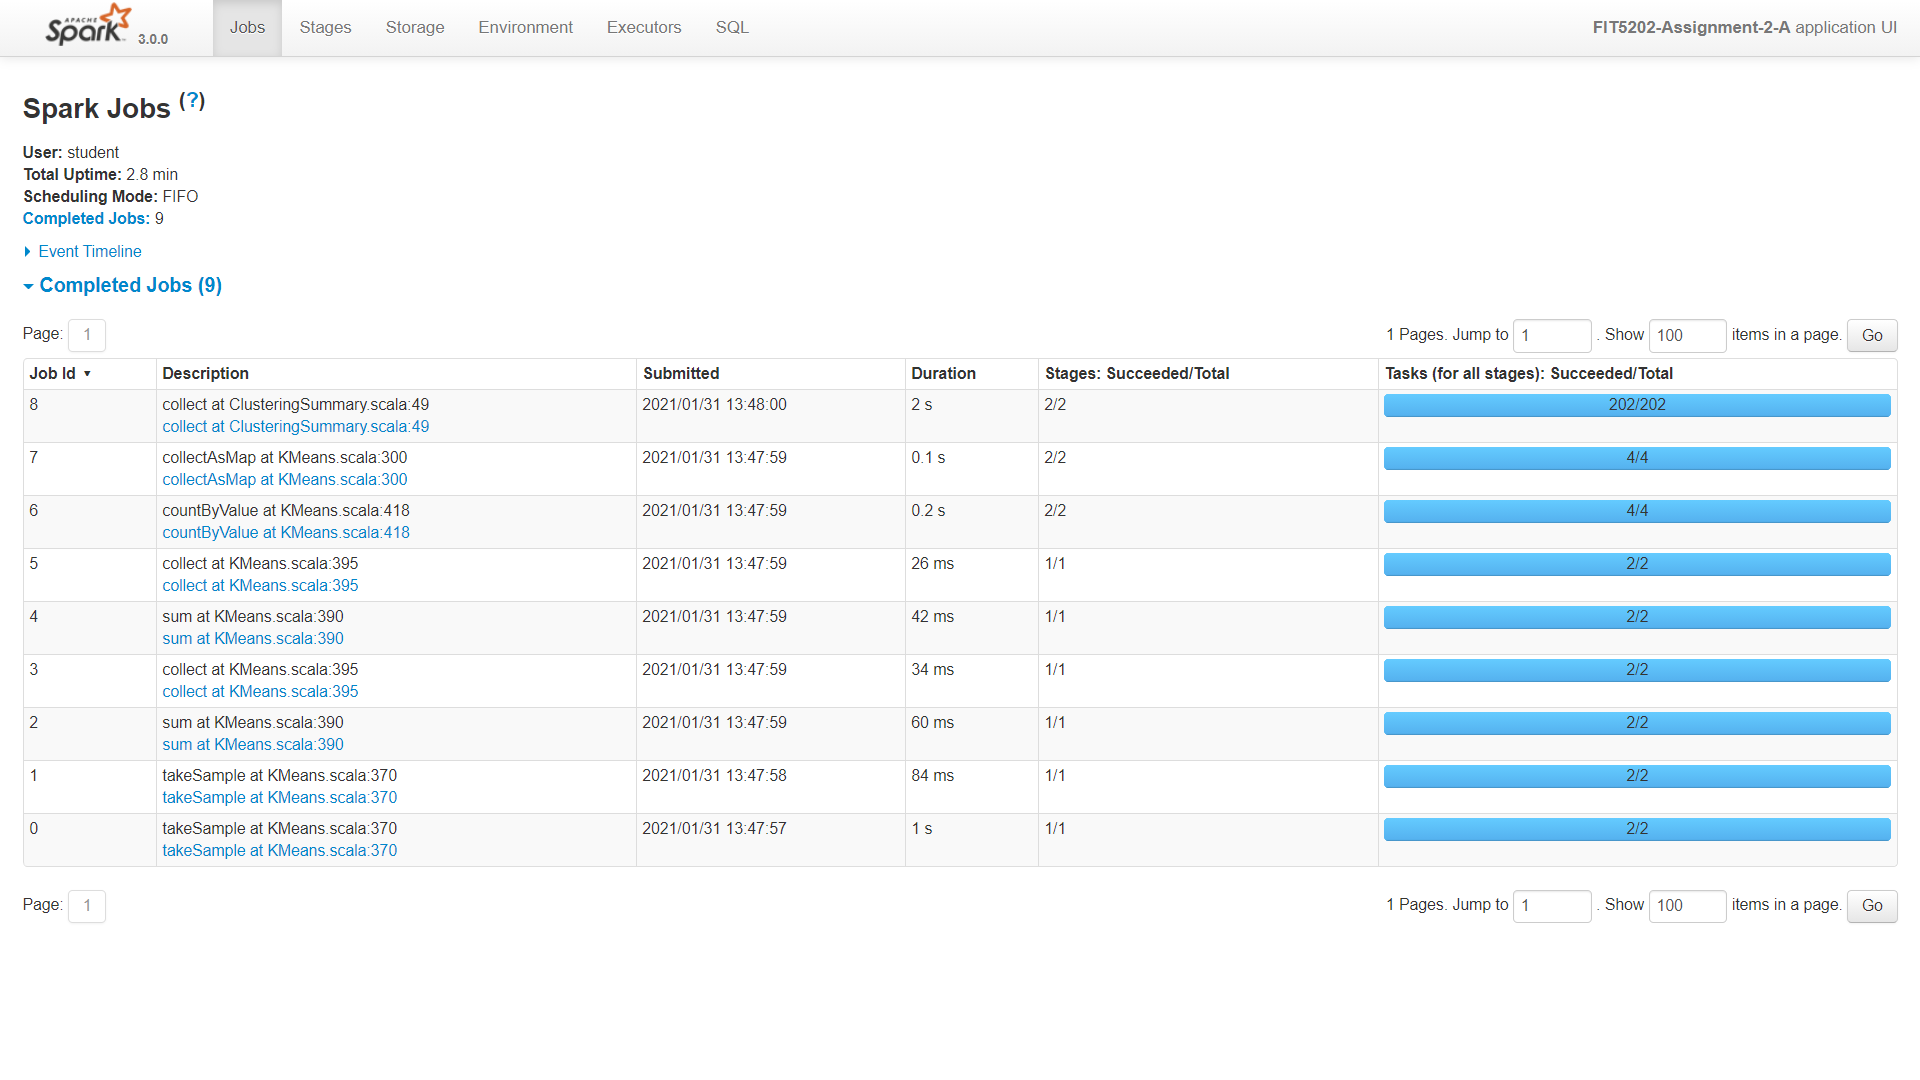
### Screenshot 2
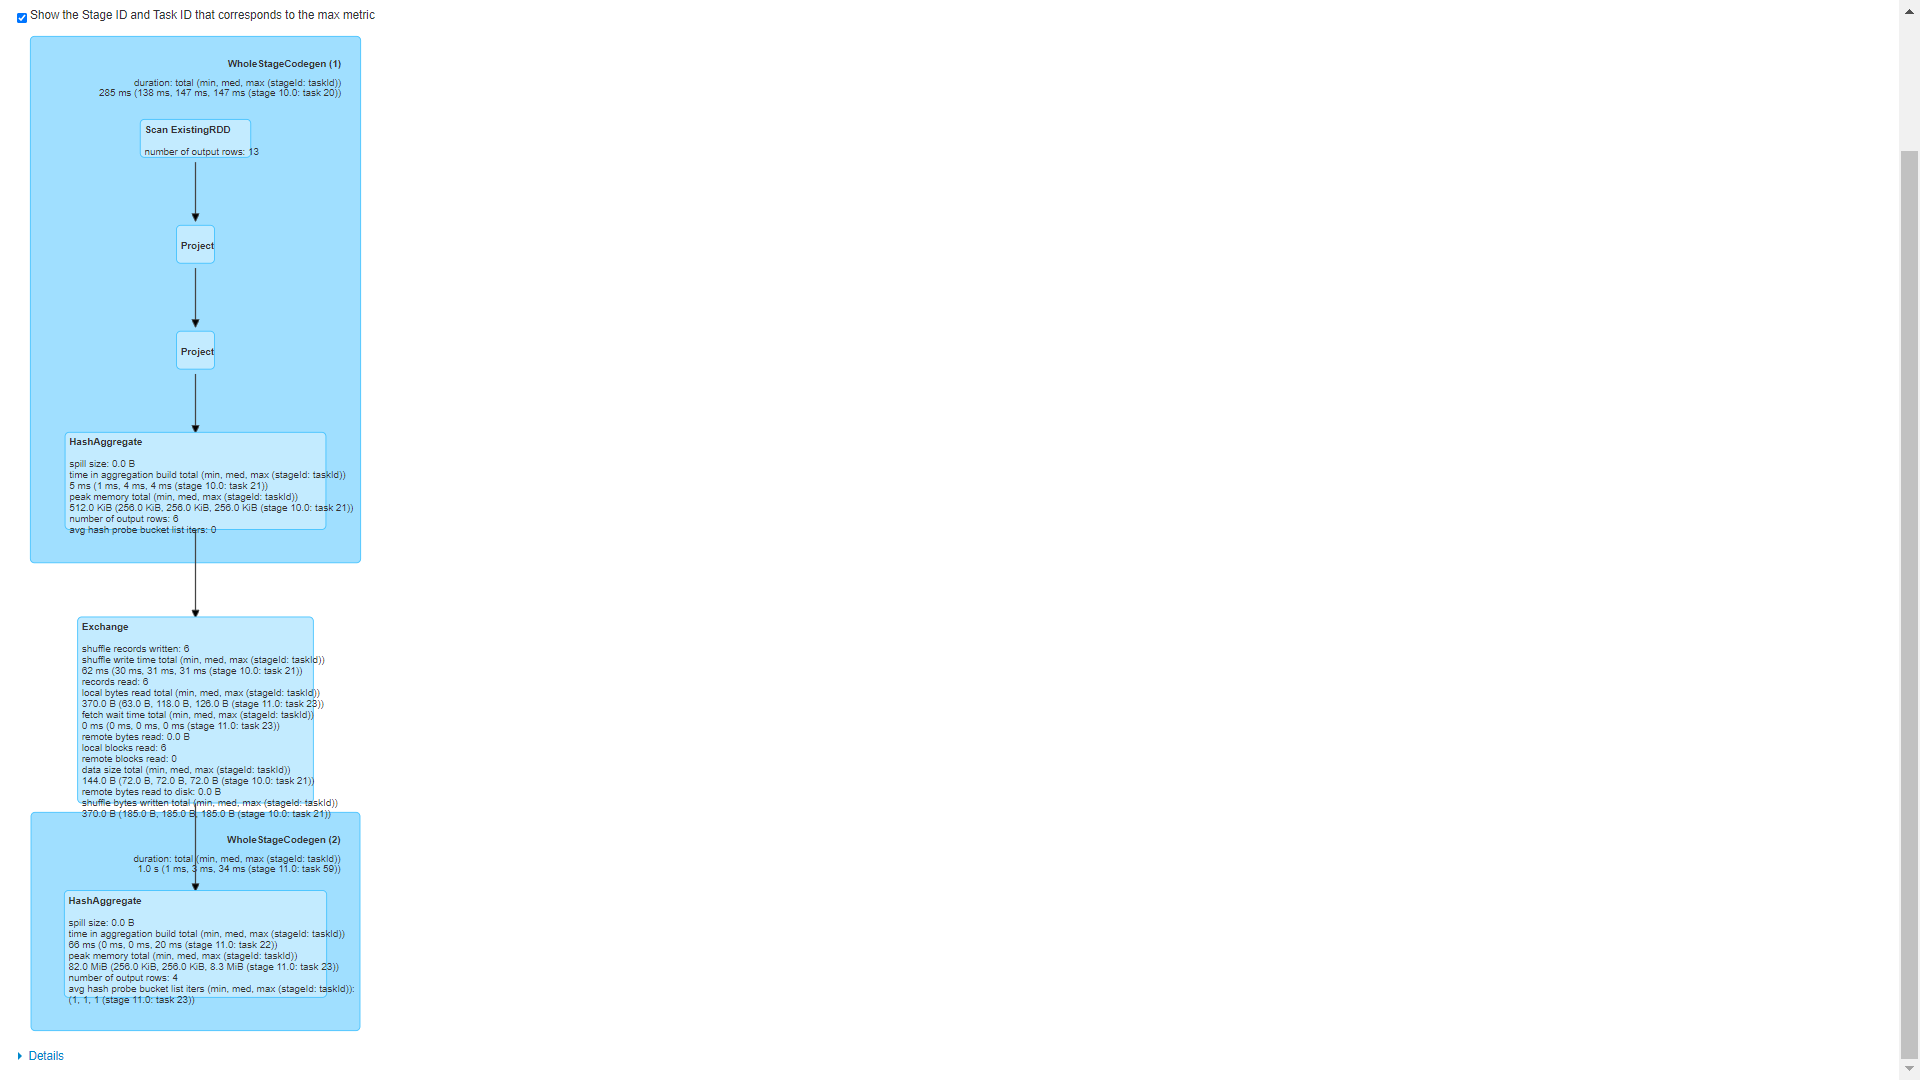

<a class="anchor" name="kmeansexplain"></a>
<h3>K-Means Clustering Explanation</h3><p><span style="font-size: 18px;">3.1 Number of Jobs</span></p><p><span style="font-size: 14px;"><em>Total Jobs:</em><strong><em>&nbsp;8</em></strong></span></p><p><span style="font-size: 18px;">3.2 Parallelism</span></p><p><em>Number of processor available:</em> <strong>2</strong><br><em>Number of the total clusters:</em> <strong>4</strong><br><em>Parallelism achieved:</em> <strong>Data parallelism</strong></p><p>From the screenshot 2, It is clear that the model is first exchange records between processor then run clustering among that, and there is no other exchange observed. The last stage is an aggregation of data; it means results from each processor goes to the driver. This process follows the data parallelism technique where each processor run clustering in each iteration with its own data without exchanging to processors. Whereas in result parallelism data is exchanged after each iteration among the processors.</p>

<a class="anchor" name="runtimeend"></a>
## Notebook running time  

In [22]:
# Convert elapsed time to Hours:Minutes:Secounds format
def get_time_string(elapsed):
    hours, rem = divmod(elapsed, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2} Hours :{:0>2} Minutes :{:05.2f} Seconds".format(int(hours),int(minutes),seconds)

# Record notebook finish time
notebook_end_time = time.time()

print(f"Total Run time of the notebook: {get_time_string(notebook_end_time - notebook_start_time)}")

Total Run time of the notebook: 00 Hours :09 Minutes :08.24 Seconds


<h3 style="text-align: center;"><strong><em><span style="color: rgb(65, 168, 95);">End of Assignment 2 Part A</span></em></strong></h3>